# Final Major Project Code

In [10]:
import pathlib
import tensorflow as tf
import os
from tensorflow import keras
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet152V2, InceptionV3, EfficientNetB3, DenseNet201, VGG16
from tensorflow.keras.models import Model
from keras.layers import GlobalAveragePooling2D, Flatten, BatchNormalization, Dense, Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
import scipy
import matplotlib.pyplot as plt

In [2]:
train_dir_cropped = 'RFMID - Cropped\\Train'
test_dir_cropped = 'RFMID - Cropped\\Test'
val_dir_cropped = 'RFMID - Cropped\\Validation'

img_height = 300
img_width = 300
batch_size = 16
epochs = 10

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
train_generator = train_datagen.flow_from_directory(
    train_dir_cropped,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
)

validation_generator = test_datagen.flow_from_directory(
    val_dir_cropped,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir_cropped,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 2021 images belonging to 7 classes.
Found 662 images belonging to 7 classes.
Found 767 images belonging to 7 classes.


# Base Classifiers

## InceptionV3

In [5]:
# Model 1

base_model = InceptionV3(
    input_shape = (300,300,3),
    weights = "imagenet",
    include_top = False
)

for layer in base_model.layers[:10]:
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.4)(x)

predictions = Dense(7, activation='softmax')(x)
model1 = Model(inputs=base_model.inputs, outputs = predictions)

In [6]:
# Checkpoints

from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath1 = "Models/InceptionV3 - {epoch:02d} - {val_accuracy:.4f}.hdf5"
model_filepath2 = "Models/InceptionV3 - {epoch:02d} - {accuracy:.4f}.hdf5"
checkpoint1 = ModelCheckpoint(
    filepath = model_filepath1,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)
checkpoint2 = ModelCheckpoint(
    filepath = model_filepath2,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [11]:
model1.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
with tf.device("/device:GPU:0"):
    history = model1.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // batch_size,
        epochs=epochs,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks = [checkpoint1, checkpoint2]
    )

Epoch 1/10
126/126 [==============================] - ETA: 0s - loss: 1.4282 - accuracy: 0.4683
Epoch 1: val_accuracy improved from -inf to 0.17378, saving model to Models\InceptionV3 - 01 - 0.1738.hdf5

Epoch 1: accuracy improved from -inf to 0.46833, saving model to Models\InceptionV3 - 01 - 0.4683.hdf5
126/126 [==============================] - 68s 483ms/step - loss: 1.4282 - accuracy: 0.4683 - val_loss: 22.0149 - val_accuracy: 0.1738
Epoch 2/10
126/126 [==============================] - ETA: 0s - loss: 1.2722 - accuracy: 0.4663
Epoch 2: val_accuracy improved from 0.17378 to 0.41311, saving model to Models\InceptionV3 - 02 - 0.4131.hdf5

Epoch 2: accuracy did not improve from 0.46833
126/126 [==============================] - 49s 389ms/step - loss: 1.2722 - accuracy: 0.4663 - val_loss: 1.6023 - val_accuracy: 0.4131
Epoch 3/10
126/126 [==============================] - ETA: 0s - loss: 1.2096 - accuracy: 0.5047
Epoch 3: val_accuracy did not improve from 0.41311

Epoch 3: accuracy impr

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

In [ ]:
model1.save('Models/inceptionV3.h5')

## ResNet152

In [5]:
# Model 2

base_model = ResNet152V2(
    input_shape = (300,300,3),
    weights = "imagenet",
    include_top = False
)

for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(7, activation='softmax')(x)
model2 = Model(inputs=base_model.inputs, outputs = predictions)

In [6]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath1 = "Models/ResNet152V2 - {epoch:02d} - {val_accuracy:.4f}.hdf5"
model_filepath2 = "Models/ResNet152V2 - {epoch:02d} - {accuracy:.4f}.hdf5"
checkpoint1 = ModelCheckpoint(
    filepath = model_filepath1,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)
checkpoint2 = ModelCheckpoint(
    filepath = model_filepath2,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [7]:
model2.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

with tf.device("/device:GPU:0"):
    history2 = model2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

Epoch 1/100


InvalidArgumentError: Graph execution error:

Detected at node 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits' defined at (most recent call last):
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\ipkernel.py", line 359, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\ipkernel.py", line 446, in do_execute
      res = shell.run_cell(
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\Asfaan Hussain\AppData\Local\Temp\ipykernel_1180\225745233.py", line 8, in <module>
      history2 = model2.fit(
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 1564, in fit
      tmp_logs = self.train_function(iterator)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 1160, in train_function
      return step_function(self, iterator)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 1146, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 1135, in run_step
      outputs = model.train_step(data)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 994, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
      return self.compiled_loss(
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\losses.py", line 152, in __call__
      losses = call_fn(y_true, y_pred)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\losses.py", line 272, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\losses.py", line 2084, in sparse_categorical_crossentropy
      return backend.sparse_categorical_crossentropy(
    File "c:\Users\Asfaan Hussain\anaconda3\envs\tensorflow_development\lib\site-packages\keras\backend.py", line 5630, in sparse_categorical_crossentropy
      res = tf.nn.sparse_softmax_cross_entropy_with_logits(
Node: 'sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits'
logits and labels must have the same first dimension, got logits shape [1,7] and labels shape [7]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_35338]

## EfficientNetB3

In [6]:
# Model 3

base_model = EfficientNetB3(
    input_shape = (300,300,3),
    weights = "imagenet",
    include_top = False
)

for layer in base_model.layers[:10]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dropout(0.3)(x)

predictions = Dense(7, activation='softmax')(x)
model3 = Model(inputs=base_model.inputs, outputs = predictions)

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint

model_filepath1 = "Models/EfficientNetB3 - {epoch:02d} - {val_accuracy:.4f}.hdf5"
model_filepath2 = "Models/EfficientNetB3 - {epoch:02d} - {accuracy:.4f}.hdf5"
checkpoint1 = ModelCheckpoint(
    filepath = model_filepath1,
    monitor = 'val_accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)
checkpoint2 = ModelCheckpoint(
    filepath = model_filepath2,
    monitor = 'accuracy',
    mode = 'max',
    save_best_only = True,
    verbose = 1
)

In [9]:
model3.compile(
    optimizer='adam',
    loss=tf.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

with tf.device("/device:GPU:0"):
    history3 = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
)

model3.save_weights(filepath='EfficientNetB3.h5', overwrite=True)

Epoch 1/50
505/505 [==============================] - 142s 256ms/step - loss: 1.5205 - accuracy: 0.4110 - val_loss: 2.2248 - val_accuracy: 0.3667
Epoch 2/50
505/505 [==============================] - 127s 251ms/step - loss: 1.3980 - accuracy: 0.4487 - val_loss: 3.0220 - val_accuracy: 0.1667
Epoch 3/50
505/505 [==============================] - 121s 240ms/step - loss: 1.3144 - accuracy: 0.4705 - val_loss: 2.7496 - val_accuracy: 0.1409
Epoch 4/50
505/505 [==============================] - 122s 242ms/step - loss: 1.3423 - accuracy: 0.4735 - val_loss: 2.1043 - val_accuracy: 0.3621
Epoch 5/50
505/505 [==============================] - 122s 242ms/step - loss: 1.2802 - accuracy: 0.4968 - val_loss: 2.5889 - val_accuracy: 0.1742
Epoch 6/50
505/505 [==============================] - 122s 242ms/step - loss: 1.2021 - accuracy: 0.5067 - val_loss: 6.7230 - val_accuracy: 0.1318
Epoch 7/50
505/505 [==============================] - 121s 240ms/step - loss: 1.1956 - accuracy: 0.5087 - val_loss: 2.7608 -

In [11]:
model3.save('Models/EfficientNetB3model.h5')

TypeError: Unable to serialize [2.0896919 2.1128857 2.1081853] to JSON. Unrecognized type <class 'tensorflow.python.framework.ops.EagerTensor'>.

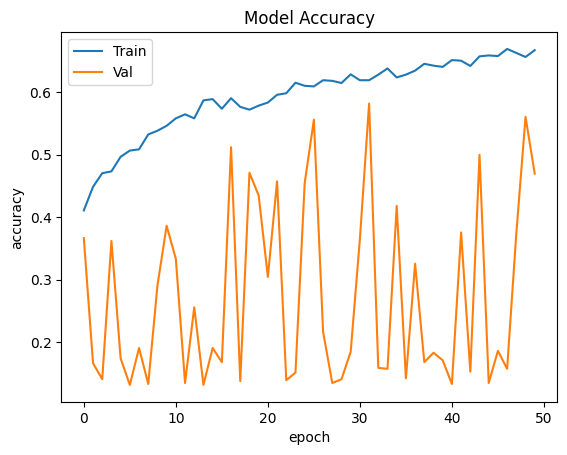

In [15]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()

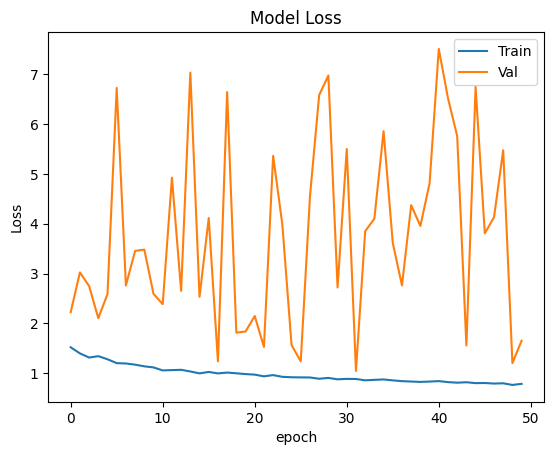

In [16]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'])
plt.show()